In [690]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components#n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)

import io
import pickle
import zipfile

###########
# import our libraries
from blue_conduit_spatial.utilities import *
from blue_conduit_spatial.evaluation import *
from blue_conduit_spatial.distance_matrix import *

LAT_MIN, LAT_MAX = 42.97, 43.09
LON_MIN, LON_MAX = -83.75, -83.62

########### set random state
np.random.seed(297)

# Load train/test data, baseline xgboost predictions, and distance data for the graph

In [691]:
# load train and test data
Xtrain, Xtest, Ytrain, Ytest = load_datasets('../data/processed')

# clean train and test data (only eliminating the homes with missing LAT/LON)
bad_train_indices = (Xtrain[Xtrain['Latitude']==-1.0]).index.values
bad_test_indices = (Xtest[Xtest['Latitude']==-1.0]).index.values
Xtrain = Xtrain.drop(bad_train_indices)
Xtest = Xtest.drop(bad_test_indices)
Ytrain = Ytrain.drop(bad_train_indices)
Ytest = Ytest.drop(bad_test_indices)

for arr, name in zip([Xtrain, Xtest, Ytrain, Ytest], ['Xtrain', 'Xtest', 'Ytrain', 'Ytest']):
    print(name, arr.shape)

Xtrain (20082, 303)
Xtest (6775, 303)
Ytrain (20082, 4)
Ytest (6775, 4)


In [100]:
# load jared model predictions
jared_train_pred = pd.read_csv('../data/processed/predictions/jared_train_yhat.csv').values
jared_test_pred = pd.read_csv('../data/processed/predictions/jared_test_yhat.csv').values

# use reverse of the bad indices above to eliminate the homes with missing LAT/LON
good_train_indices = np.array([i for i in range(jared_train_pred.shape[0]) if i not in bad_train_indices])
good_test_indices = np.array([i for i in range(jared_test_pred.shape[0]) if i not in bad_test_indices])
Ytrain_pred_xgboost = jared_train_pred[good_train_indices,:]
Ytest_pred_xgboost = jared_test_pred[good_test_indices,:]
print('XGBoost YTrain pred', Ytrain_pred_xgboost.shape)
print('XGBoost YTest pred', Ytest_pred_xgboost.shape)

XGBoost YTrain pred (20082, 2)
XGBoost YTest pred (6775, 2)


In [356]:
# load distance data
# this part is slow
dis_path = '../data/road_distances.npz'
distances = np.load(dis_path, allow_pickle=True)
graph = distances['road_distances']
graph[graph==(1.00e+05)]=0.0 #assign invalid 1e5 values to be 0
    
train_indices, test_indices, train_graph, test_graph = load_train_test_dist_matrices()
idx_to_train_idx = lambda idx : np.where(train_indices==idx)[0][0]
idx_to_test_idx = lambda idx : np.where(test_indices==idx)[0][0]

print('graph', graph.shape)
print('graph train', train_graph.shape)
print('graph test', test_graph.shape)


graph (26857, 26857)
graph train (20082, 20082)
graph test (6775, 6775)


# Practice diffusion on subgraph

In [654]:
# build subgraph, tracking train/test split
n_subgraph = 200
np.random.seed(538)
subgraph_idx = np.random.choice(np.arange(graph.shape[0]),n_subgraph)
subgraph = graph[subgraph_idx,:][:,subgraph_idx]

def get_lat_lon(i):
    if i in train_indices:
        return np.array([Xtrain.Latitude.values[idx_to_train_idx(i)], Xtrain.Longitude.values[idx_to_train_idx(i)]])
    elif i in test_indices:
        return np.array([Xtest.Latitude.values[idx_to_test_idx(i)], Xtest.Longitude.values[idx_to_test_idx(i)]])


print('subgraph', subgraph.shape)
print(subgraph)

subgraph (200, 200)
[[ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.   0.   0.  ...  0.  92.8  0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.  89.5  0.  ...  0.   0.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]]


In [701]:
def plot_graph(fig, ax, color_vals, title, bbox = None):

    g = nx.from_numpy_array(subgraph)
    
    # draw nodes with colors
    graph_pos = {i : get_lat_lon(idx) for i, idx in enumerate(subgraph_idx)}
    nx.draw_networkx_nodes(g, graph_pos, node_color=color_vals, vmin=0,vmax=1,cmap = cm.RdYlGn_r, ax=ax)
    
    # grab edge weights
    all_weights = []
    for (_,_,data) in g.edges(data=True):
        all_weights.append(data['weight'])
    unique_weights = list(set(all_weights))
    
    # draw weights one at a time
    for weight in unique_weights:
        weighted_edges = np.array([(node1,node2) for (node1,node2,edge_attr) in g.edges(data=True) if edge_attr['weight']==weight])
        alpha = 25*weight/sum(all_weights)
        nx.draw_networkx_edges(g,graph_pos,edgelist=weighted_edges,width=100*alpha,ax=ax, alpha = alpha)

    # add color scale
    cb = fig.colorbar(cm.ScalarMappable(norm=Normalize(), cmap=cm.RdYlGn_r), ax=ax)
    cb.set_label('LEAD value')
    
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    limits=ax.axis('on')
    if bbox is None:
        ax.set_xlim(LAT_MIN, LAT_MAX)
        ax.set_ylim(LON_MIN, LON_MAX)
    else:
        ax.set_xlim(bbox[0], bbox[1])
        ax.set_ylim(bbox[2], bbox[3])

In [702]:
def get_LEAD_value(idx):
    # If train, then 1: lead, 0: no lead. If test, then return baseline xgboost probability
    if idx in train_indices:
        return Ytrain.dangerous.values[idx_to_train_idx(idx)]
    elif idx in test_indices:
        return Ytest_pred_xgboost[idx_to_test_idx(idx),1]  

def diffusion_distance_weights(distances):
    # UPDATE THIS FUNCTION ABOVE TO CHANGE HOW THE DISTANCE INFLUENCES THE WEIGHT
    return 1/(1 + distances)

def subgraph_neighbors(K):
    # get nearest neighbors for each node of the subgraph
    # replaces 0's with 1e7 because the sklearn implementation treats a distance of 0 as a valid distance
    nn = NearestNeighbors(n_neighbors=K, metric='precomputed')
    neighbors_subgraph = subgraph.copy()
    neighbors_subgraph[neighbors_subgraph==0] = 1e7
    nn.fit(neighbors_subgraph)
    return nn.kneighbors()

def diffusion_step(LEAD, verbose=False):
    # UPDATE THIS FUNCTION ABOVE TO CHANGE HOW WE INCORPORATE NEIGHBOR PROBABILITIES
    
    # number of nearest neighbors
    K = 5
    neighbor_dis, neighbor_idx = subgraph_neighbors(K)
    neighbor_weights = diffusion_distance_weights(neighbor_dis)
    
    weighted_avg_neighbor_lead = np.average(LEAD[neighbor_idx], axis=1, weights = neighbor_weights)
    
    def update_node(node_val, node_idx):
        if node_val in [0., 1.]:
            return node_val
        return 0.5*node_val + 0.5*weighted_avg_neighbor_lead[node_idx]
        
    outputs = np.array([update_node(node_val, node_idx) for node_idx, node_val in enumerate(LEAD)])
    
    if verbose:
        
        # show neighbor influence
        for i, idx in enumerate(subgraph_idx):
            print('Node', i)
            print('\told LEAD value', get_LEAD_value(idx))
            neighbor_lead = LEAD[neighbor_idx[i,:]]
            for k in range(K):
                print(f'\t Neighbor {neighbor_idx[i,k]} : dist {neighbor_dis[i,k]}, weight {np.round(neighbor_weights[i,k],3)}, LEAD value {np.round(neighbor_lead[k],3)}')
            print('\t new LEAD value:', outputs[i])
        
        # show overall probability shifts
        print('pre-diff LEAD values --> post-diff LEAD values')
        for p1, p2 in zip(LEAD, outputs):
            print(f'{np.round(p1,2)} --> {np.round(p2,2)}')
        
    return outputs


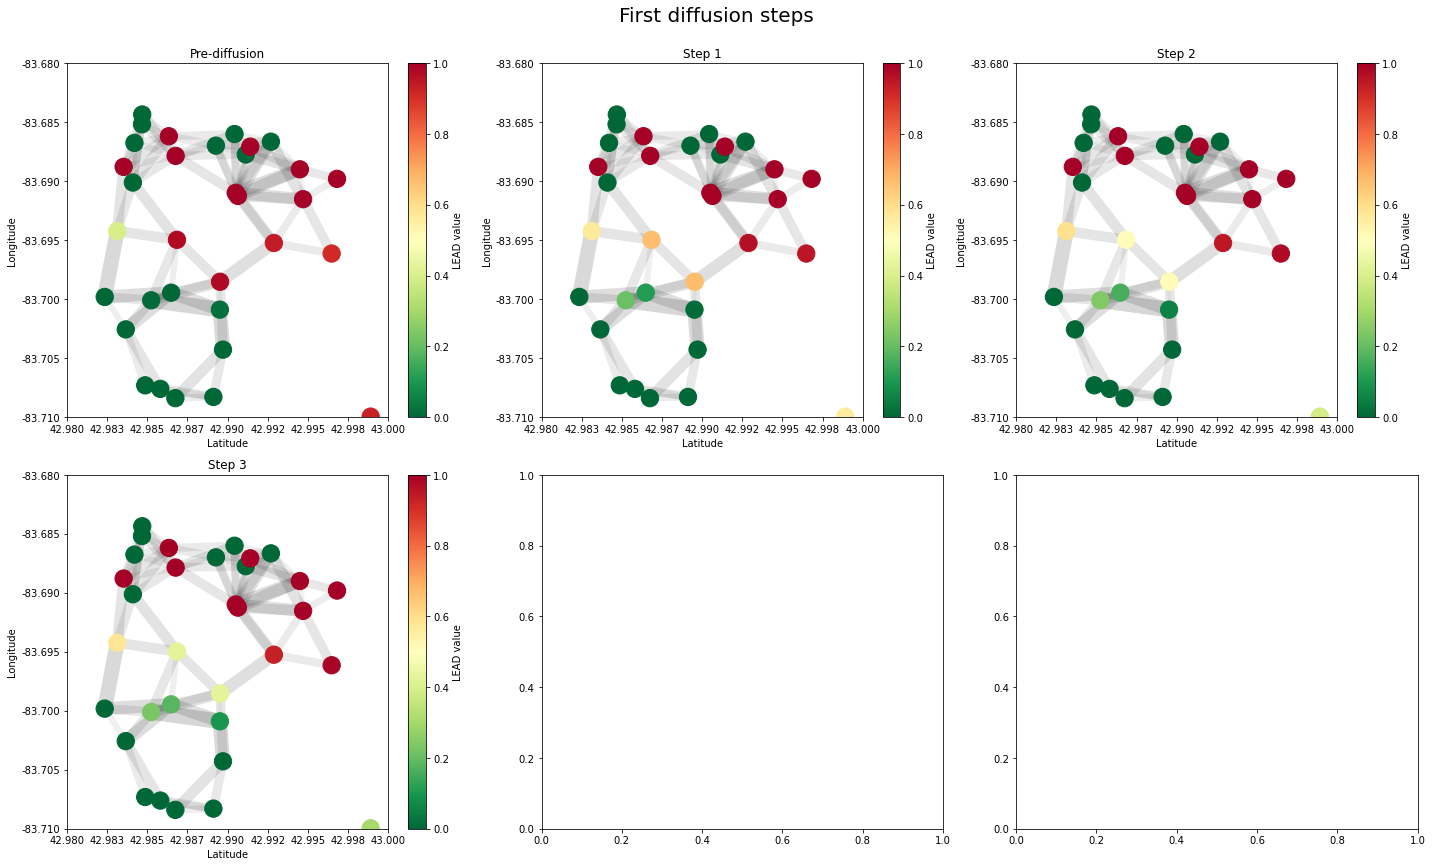

In [703]:
def diffusion(n_steps = 3):
    # plot subgraph pre and post diffusion
    nrows = (n_steps+3)//3
    ncols = 3
    fig, axes = plt.subplots(nrows, ncols, figsize=(20,6*nrows))
    plt.suptitle('First diffusion steps', fontsize=20, y = 1)
    
    # zooming in on a particular neighborhood
    LAT_MIN_SUB, LAT_MAX_SUB = 42.98, 43.00
    LON_MIN_SUB, LON_MAX_SUB = -83.71, -83.68
    bbox = [LAT_MIN_SUB, LAT_MAX_SUB, LON_MIN_SUB, LON_MAX_SUB]
    
    initial_LEAD_values = np.array([get_LEAD_value(idx) for idx in subgraph_idx])
    
    # plot initial LEAD values
    if nrows==1:
        plot_graph(fig, axes[0], initial_LEAD_values, 'Pre-diffusion', bbox = bbox)
    else:
        plot_graph(fig, axes[0,0], initial_LEAD_values, 'Pre-diffusion', bbox = bbox)

    # run diffusion for n_steps
    prev_outputs = initial_LEAD_values
    for step in range(1, n_steps+1):
        if nrows == 1:
            ax = axes[step%ncols]
        else:
            ax = axes[step//ncols,step%ncols]
        step_outputs = diffusion_step(prev_outputs)
        plot_graph(fig, ax, step_outputs, f'Step {step}', bbox = bbox)
        prev_outputs = step_outputs
    plt.tight_layout()
    plt.show()
        
diffusion(n_steps=3)